In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from tensorflow.keras.utils import plot_model

# Краткое описание задачи

Цель исследования - обучить нейросеть предсказывать концентрацию H2S и CO2 в ppm. 

В рамках исследования рассматривается аминовый абсорбер. На верхнюю ступень подается раствор MDEA (lean_amine),
под нижнюю ступень подается углеводородный газ (feed_gas). Сверха колонны отбирается
очищенный углеводородный газ (sweet_gas), а снизу колонны - насыщенный амин (lean_amine).

# Исходный набор данных

In [2]:
data = pd.read_csv('./data/amine_treatment-final.csv')
data

,"feed_gas temperature, C","feed_gas pressure, kPa","feed_gas mass flow, kg/h",feed_gas molecular weight,"feed_gas Mass density, kg/m3","feed_gas actual liquid flow, m3/h","feed_gas actual vapour flow, m3/h",feed_gas CO2 mol frac,feed_gas Methane mol frac,feed_gas Ethane mol frac,...,degased_amine Propane mol frac,degased_amine i-Butane mol frac,degased_amine n-Butane mol frac,degased_amine i-Pentane mol frac,degased_amine n-Pentane mol frac,degased_amine H2S mol frac,degased_amine H2O mol frac,degased_amine MDEAmine mol frac,degased_amine H2S ppm,degased_amine CO2 ppm
0,52.0,6701.325,259647.0,24.668523,80.705482,0.000000,3217.216383,0.031875,0.633122,0.192729,...,0.000004,1.979803e-06,6.785930e-06,3.039502e-08,1.629357e-07,0.014838,0.910916,0.062270,22521.880092,23245.607009
1,40.0,6701.325,63853.0,23.411939,79.292250,0.000000,805.286774,0.039520,0.681947,0.179992,...,0.000006,1.099164e-07,7.886635e-07,2.425456e-06,2.679624e-08,0.010470,0.896612,0.077190,15891.219056,30468.484150
2,46.0,6701.325,15928.0,27.803853,108.358884,0.000000,146.993024,0.027859,0.577870,0.163095,...,0.000018,5.179434e-05,2.863001e-05,4.721545e-06,1.359401e-06,0.001284,0.860268,0.132676,1949.372531,10648.306282
3,36.0,6701.325,150276.0,22.053344,74.092459,0.000000,2028.222609,0.005420,0.856717,0.000249,...,0.000039,8.734358e-06,3.706189e-05,5.426945e-05,3.949909e-06,0.001233,0.809722,0.184359,1871.528366,8438.736973
4,12.0,6701.325,52691.0,24.334510,114.182302,0.002870,461.460940,0.027297,0.694634,0.091063,...,0.000100,7.719691e-05,2.661312e-05,1.351350e-05,6.619552e-06,0.003300,0.788340,0.200715,5008.207346,14011.150105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512795,18.0,6701.325,278813.0,27.267819,147.437736,0.239690,1890.816202,0.036621,0.666807,0.042159,...,0.000053,1.226987e-04,3.336251e-05,4.145371e-06,8.510407e-06,0.002101,0.796328,0.187149,3188.443718,27411.897443
512796,33.0,6701.325,72612.0,26.629816,112.530303,0.000000,645.266193,0.025383,0.605142,0.150361,...,0.000049,8.271254e-05,1.199104e-05,1.810930e-06,4.749955e-06,0.003784,0.826966,0.162727,5742.847844,11941.343733
512797,17.0,6701.325,272718.0,26.290335,135.390018,0.133398,2014.180541,0.039356,0.606850,0.167318,...,0.000037,2.874297e-05,3.343060e-06,1.045919e-05,2.187381e-06,0.045335,0.725301,0.179546,68812.636471,97071.672175
512798,59.0,6701.325,75970.0,24.231673,73.727565,0.000000,1030.415146,0.037951,0.732049,0.086286,...,0.000013,1.782460e-05,8.286743e-06,5.417825e-06,2.393693e-07,0.002551,0.877567,0.106280,3871.441495,26287.366187


Исходная таблицы содержит 121 параметр. Для обучения нейросети, которая будет предсказывать содержание кислых
компонентов, необходимо сократить количество параметров.
Исходный набор данных не содержит информации по молярному расходу кислых компонентов и молярных расходом основных потоков 
поэтому необходимо их расчитать отдельно. 

In [4]:
data['rich_amine molar flow, kgmol/h'] = data['rich_amine mass flow, kg/h'] / data['rich_amine molecular weight']
data['rich_amine H2S molar flow, kgmol/h'] = data['rich_amine molar flow, kgmol/h'] * data['rich_amine H2S mol frac']
data['rich_amine CO2 molar flow, kgmol/h'] = data['rich_amine molar flow, kgmol/h'] * data['rich_amine CO2 mol frac']
data['rich_amine H2O molar flow, kgmol/h'] = data['rich_amine molar flow, kgmol/h'] * data['rich_amine H2O mol frac']
data['rich_amine MDEAmine molar flow, kgmol/h'] = data['rich_amine molar flow, kgmol/h'] * data['rich_amine MDEAmine mol frac']
data['rich_amine sour comp molar flow, kgmol/h'] = data['rich_amine H2S molar flow, kgmol/h'] + data['rich_amine CO2 molar flow, kgmol/h']

data['feed_gas molar flow, kgmol/h'] = data['feed_gas mass flow, kg/h'] / data['feed_gas molecular weight']
data['feed_gas H2S molar flow, kgmol/h'] = data['feed_gas molar flow, kgmol/h'] * data['feed_gas H2S mol frac']
data['feed_gas CO2 molar flow, kgmol/h'] = data['feed_gas molar flow, kgmol/h'] * data['feed_gas CO2 mol frac']
data['feed_gas H2O molar flow, kgmol/h'] = data['feed_gas molar flow, kgmol/h'] * data['feed_gas H2O mol frac']
data['feed_gas MDEAmine molar flow, kgmol/h'] = data['feed_gas molar flow, kgmol/h'] * data['feed_gas MDEAmine mol frac']


data['lean_amine molar flow, kgmol/h'] = data['lean_amine mass flow, kg/h'] / data['lean_amine molecular weight']
data['lean_amine H2S molar flow, kgmol/h'] = data['lean_amine molar flow, kgmol/h'] * data['lean_amine H2S mol frac']
data['lean_amine CO2 molar flow, kgmol/h'] = data['lean_amine molar flow, kgmol/h'] * data['lean_amine CO2 mol frac']
data['lean_amine H2O molar flow, kgmol/h'] = data['lean_amine molar flow, kgmol/h'] * data['lean_amine H2O mol frac']
data['lean_amine MDEAmine molar flow, kgmol/h'] = data['lean_amine molar flow, kgmol/h'] * data['lean_amine MDEAmine mol frac']

data['sweet_gas molar flow, kgmol/h'] = data['sweet_gas mass flow, kg/h'] / data['sweet_gas molecular weight']
data['sweet_gas H2S molar flow, kgmol/h'] = data['sweet_gas molar flow, kgmol/h'] * data['sweet_gas H2S mol frac']
data['sweet_gas CO2 molar flow, kgmol/h'] = data['sweet_gas molar flow, kgmol/h'] * data['sweet_gas CO2 mol frac']
data['sweet_gas H2O molar flow, kgmol/h'] = data['sweet_gas molar flow, kgmol/h'] * data['sweet_gas H2O mol frac']
data['sweet_gas MDEAmine molar flow, kgmol/h'] = data['sweet_gas molar flow, kgmol/h'] * data['sweet_gas MDEAmine mol frac']

Ниже представлен набор данных, который будет непосредственно влиять на уровень кислых компонентов в очищенном газе. Так же в этот набор данных введен столбец 'sweet_gas H2S ppm'. Это сделанно для создания корреляционной матрицы

In [5]:
# Необходимо свести в таблицу все параметры указанные тут
training_data = data[[
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'feed_gas molecular weight', 'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h',
    'feed_gas CO2 molar flow, kgmol/h',
    'lean_amine molecular weight', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h',
    'lean_amine CO2 molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight', 
    'rich_amine molar flow, kgmol/h',
    'sweet_gas temperature, C', 'sweet_gas mass flow, kg/h', 'sweet_gas molecular weight', 
    'sweet_gas molar flow, kgmol/h', 'sweet_gas H2S ppm'
]]

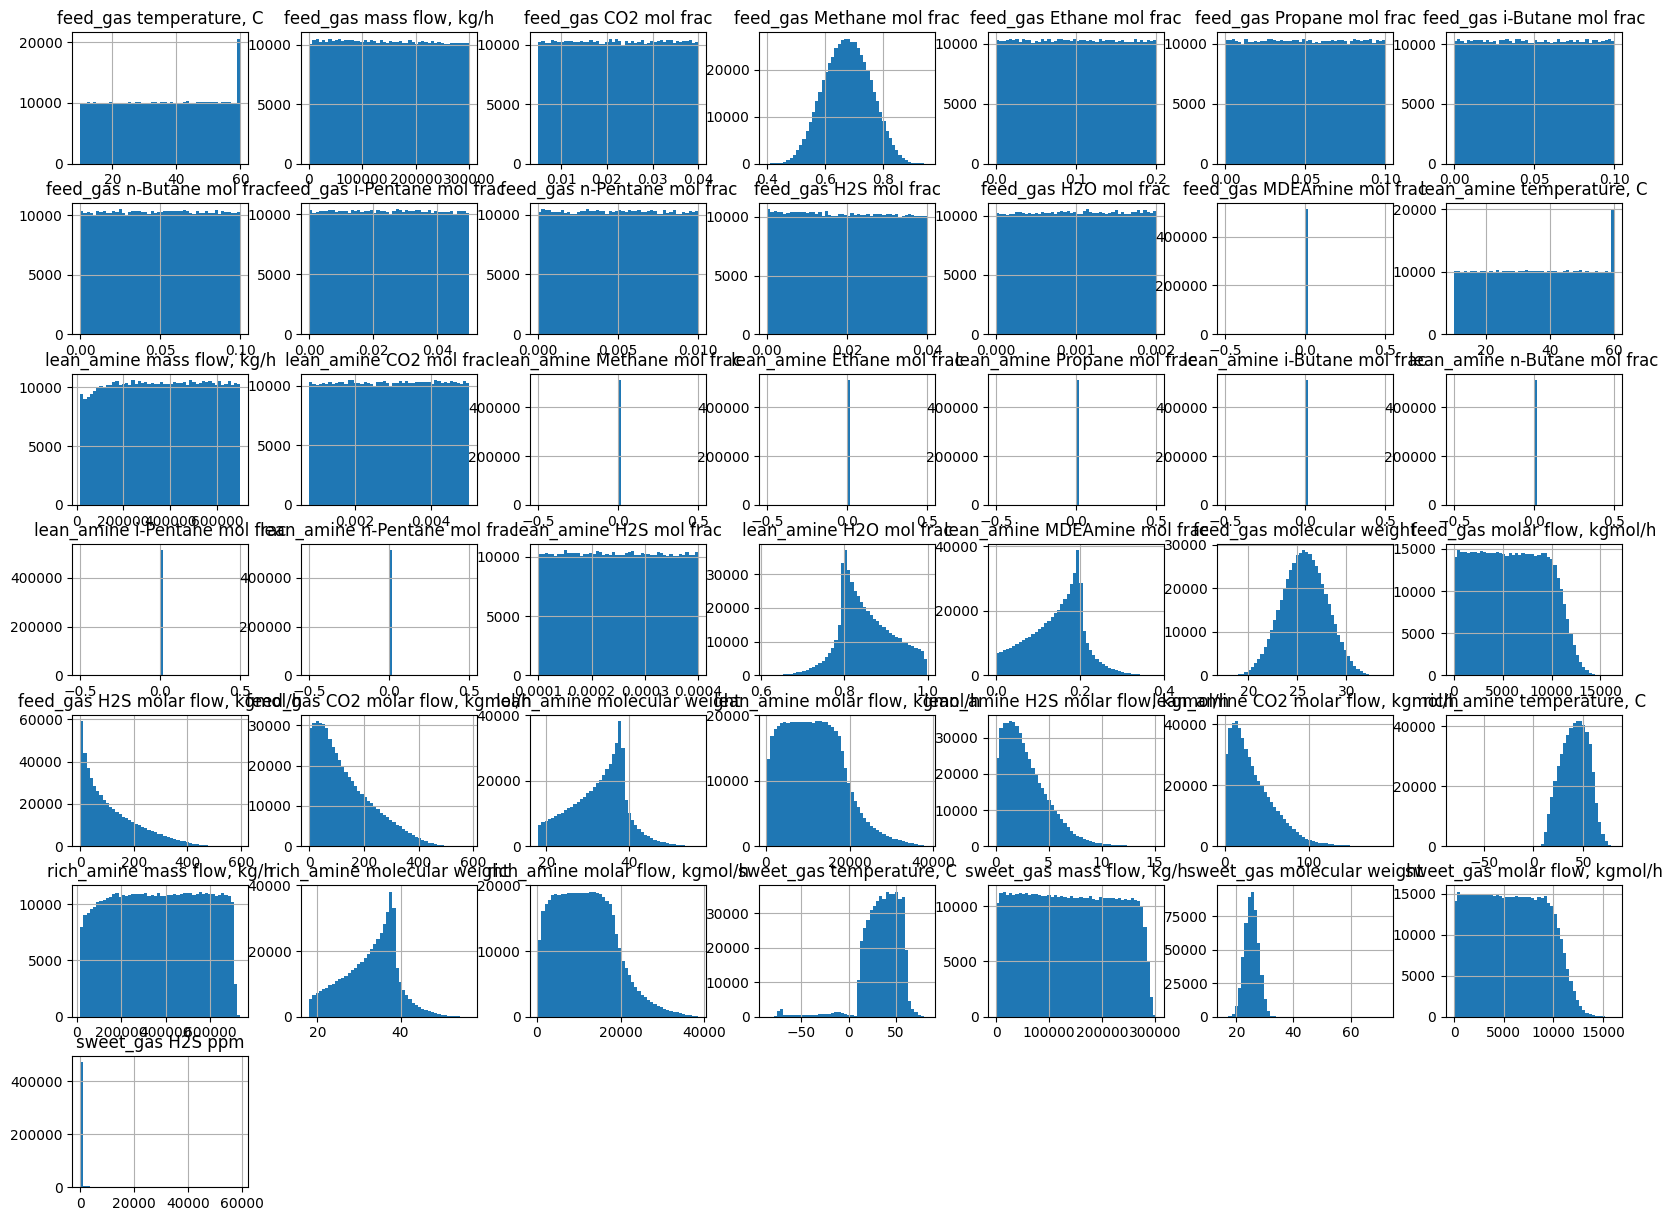

In [6]:
# Графики ниже показывают распределение значений каждого столбца по которым можно судить о качестве набора данных
training_data.hist(bins=50, figsize=(20, 15));

In [6]:
corr_matrix = training_data.corr()

corr_matrix['sweet_gas H2S ppm'].sort_values(ascending=False)

sweet_gas H2S ppm                     1.000000
feed_gas H2S molar flow, kgmol/h      0.259889
lean_amine H2O mol frac               0.213915
feed_gas H2S mol frac                 0.170921
sweet_gas mass flow, kg/h             0.170332
sweet_gas molar flow, kgmol/h         0.162455
feed_gas mass flow, kg/h              0.154762
feed_gas molar flow, kgmol/h          0.152224
feed_gas CO2 molar flow, kgmol/h      0.139040
sweet_gas temperature, C              0.081777
feed_gas temperature, C               0.037778
feed_gas CO2 mol frac                 0.031142
sweet_gas molecular weight            0.025665
lean_amine H2S mol frac               0.003339
lean_amine temperature, C             0.002073
feed_gas H2O mol frac                 0.001974
lean_amine CO2 mol frac               0.001809
feed_gas molecular weight             0.000475
feed_gas n-Pentane mol frac          -0.002109
feed_gas Propane mol frac            -0.006168
feed_gas Ethane mol frac             -0.008639
feed_gas n-Bu

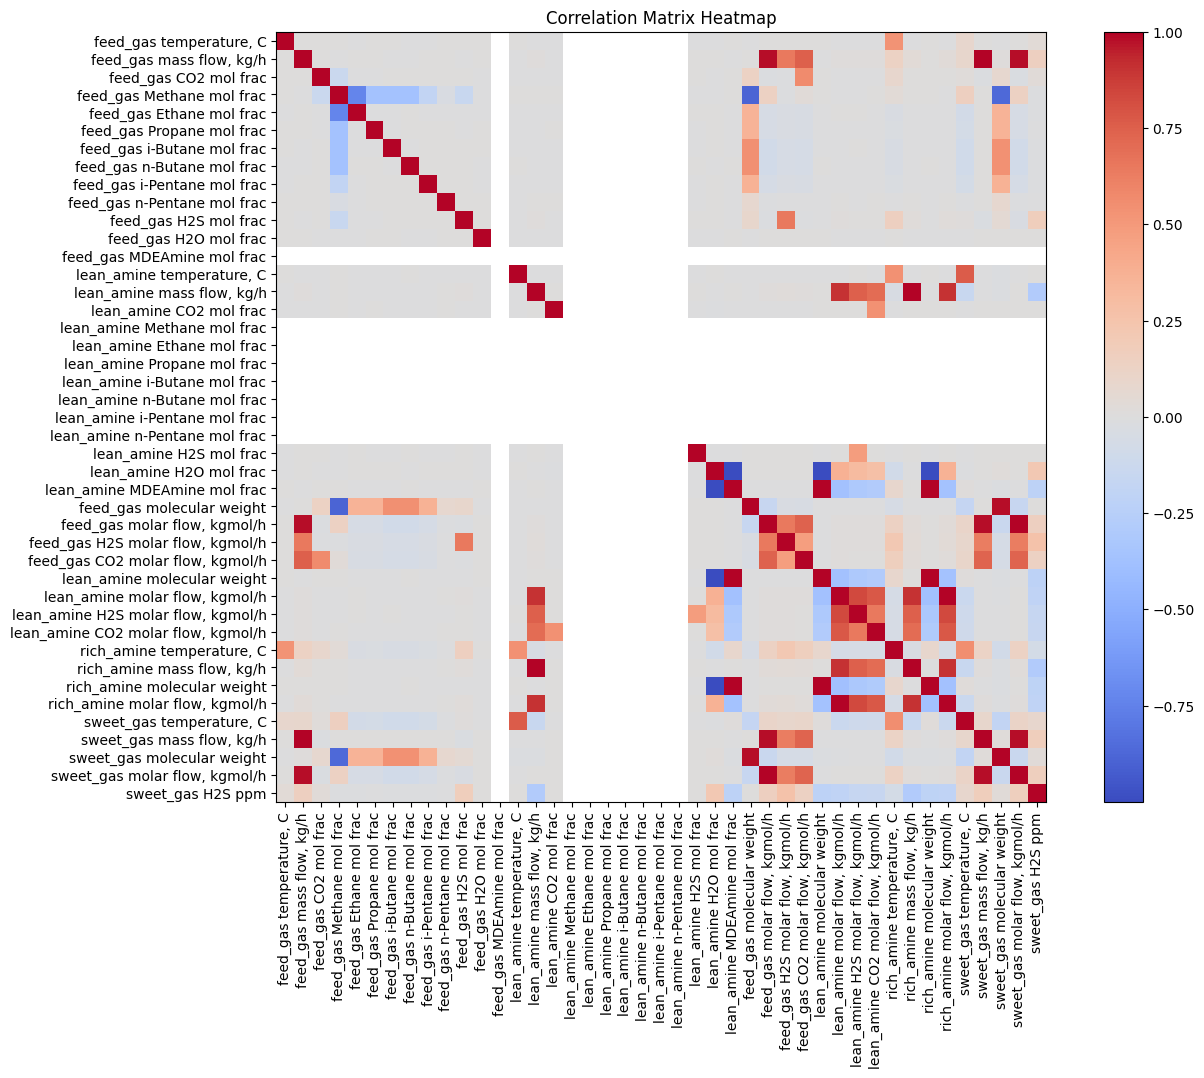

In [12]:
plt.figure(figsize=(15, 10))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix Heatmap')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.show()

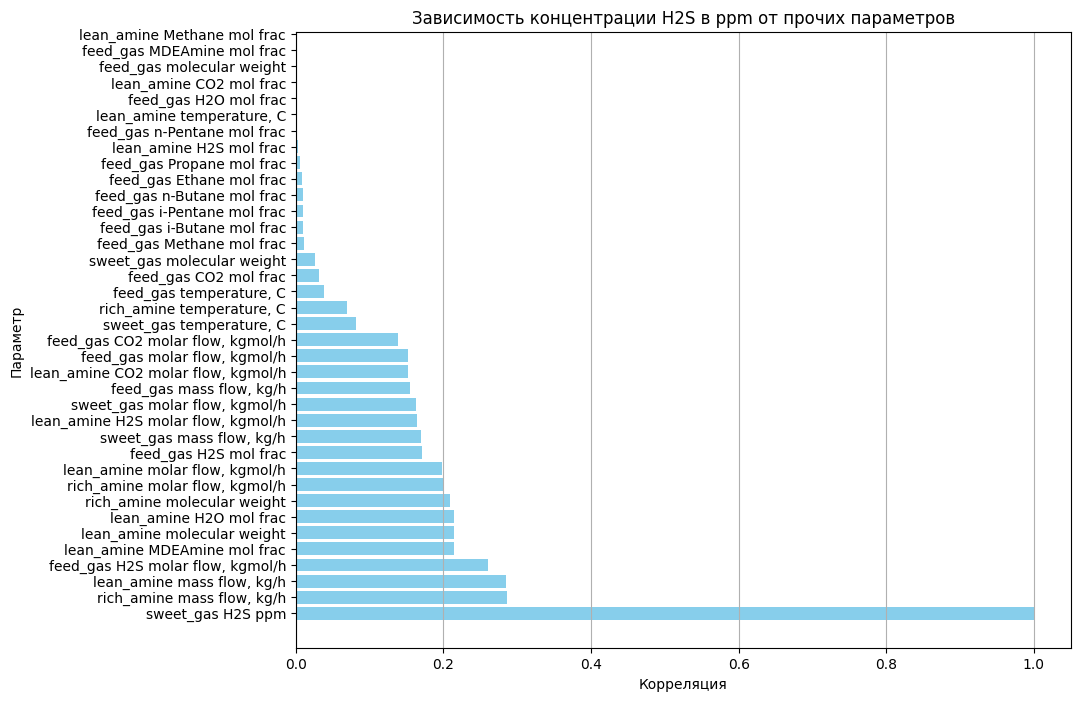

In [27]:
sorted_corr = corr_matrix['sweet_gas H2S ppm'].abs().sort_values(ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(sorted_corr.index, sorted_corr.values, color='skyblue')
plt.xlabel('Корреляция')
plt.ylabel('Параметр')
plt.title('Зависимость концентрации H2S в ppm от прочих параметров')
plt.grid(axis='x')
plt.show()

На основе выбранных данных подготавливается обучающая и тестовые выборки. Обычно распределение в обучающую выборку попадает
80% исходных данных, а в тестовую 20% исходных данных.
Далее на основе обучающей выборке обучалась нейросеть

In [37]:
X = training_data[[
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'feed_gas molecular weight', 'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h',
    'feed_gas CO2 molar flow, kgmol/h',
    'lean_amine molecular weight', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h', 'lean_amine CO2 molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight', 
    'rich_amine molar flow, kgmol/h',
    'sweet_gas temperature, C', 'sweet_gas mass flow, kg/h', 'sweet_gas molecular weight', 
    'sweet_gas molar flow, kgmol/h',
]]

y = np.log1p(training_data[['sweet_gas H2S ppm']])

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'feed_gas molecular weight', 'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h',
    'feed_gas CO2 molar flow, kgmol/h',
    'lean_amine molecular weight', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h', 'lean_amine CO2 molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight', 
    'rich_amine molar flow, kgmol/h',
    'sweet_gas temperature, C', 'sweet_gas mass flow, kg/h', 'sweet_gas molecular weight', 
    'sweet_gas molar flow, kgmol/h',
    ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((410240, 42), (410240, 1))

In [38]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
sweet_gas_H2S_ppm_model = tf.keras.Sequential([
    tf.keras.layers.Dense(42, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
sweet_gas_H2S_ppm_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
sweet_gas_H2S_ppm_model.fit(X_train_normal, y_train, epochs=20)

plot_model(sweet_gas_H2S_ppm_model, to_file='model_architecture.png', show_shapes=True)

Epoch 1/20
12820/12820 [==============================] - 18s 1ms/step - loss: 0.2419 - mae: 0.2419
Epoch 2/20
12820/12820 [==============================] - 18s 1ms/step - loss: 0.1449 - mae: 0.1449
Epoch 3/20
12820/12820 [==============================] - 17s 1ms/step - loss: 0.1264 - mae: 0.1264
Epoch 4/20
12820/12820 [==============================] - 20s 2ms/step - loss: 0.1177 - mae: 0.1177
Epoch 5/20
12820/12820 [==============================] - 19s 1ms/step - loss: 0.1105 - mae: 0.1105
Epoch 6/20
12820/12820 [==============================] - 25s 2ms/step - loss: 0.1045 - mae: 0.1045
Epoch 7/20
12820/12820 [==============================] - 26s 2ms/step - loss: 0.1024 - mae: 0.1024
Epoch 8/20
12820/12820 [==============================] - 22s 2ms/step - loss: 0.0981 - mae: 0.0981
Epoch 9/20
12820/12820 [==============================] - 23s 2ms/step - loss: 0.0953 - mae: 0.0953
Epoch 10/20
12820/12820 [==============================] - 23s 2ms/step - loss: 0.0934 - mae: 0.0934